# 04_CAM-Based

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16()
model.summary()

2022-04-29 16:17:11.281509: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-29 16:17:11.282294: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-04-29 16:17:11.282686: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
def load_imagenet_labels(labels_file):
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

imagenet_labels = load_imagenet_labels('data/ImageNetLabels.txt')

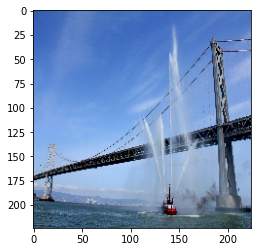

In [4]:
def read_image(img_path):
    image = tf.io.read_file(img_path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, size=(224, 224))
#     image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

image = read_image('data/fireboat.jpg')
plt.imshow(image/255)

In [5]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    inputs = preprocess_input(image_batch)
    predictions = model(inputs)
    top_probs, top_idxs = tf.math.top_k(input=predictions, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

In [6]:
pred_label, pred_prob = top_k_predictions(image)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

fireboat: 98.6%
drilling platform: 0.3%
crane: 0.2%


In [7]:
def infer_target_layer(model):

    for layer in reversed(model.layers):
        # Select closest 4D layer to the end of the network.
        if len(layer.output_shape) == 4:
            return layer.name

    raise ValueError(
        "Model does not seem to contain 4D layer. CAM-Based method cannot be applied."
    )

## [1. Grad-CAM (Ancona et al. 16)](https://arxiv.org/abs/1610.02391)

In [8]:
target_class_idx = 554

image_batch = tf.expand_dims(image, 0)
inputs = preprocess_input(image_batch)
layer_name = infer_target_layer(model)
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(layer_name).output, model.output]
)

with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(inputs)
    if target_class_idx is None:
        target_class_idx = tf.argmax(preds[0])
    class_channel = preds[:, target_class_idx]

grads = tape.gradient(class_channel, last_conv_layer_output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.math.reduce_max(heatmap)

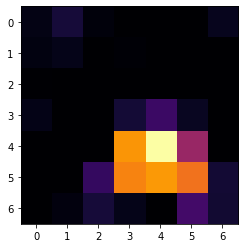

In [9]:
plt.imshow(heatmap, cmap=cm.inferno)

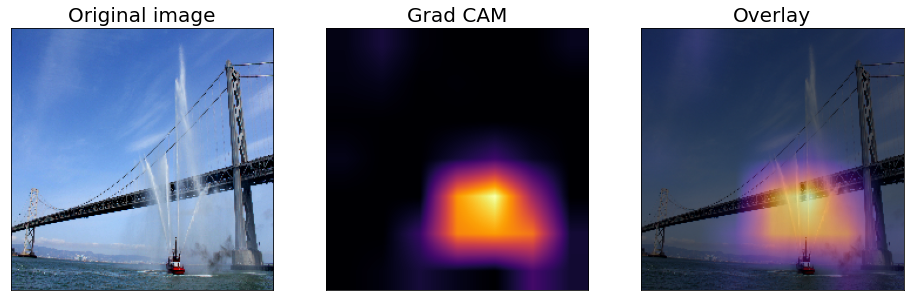

In [10]:
heatmap_3dim = tf.expand_dims(heatmap, axis=2)
attribution_mask = tf.squeeze(tf.image.resize(heatmap_3dim, size=(image.shape[1], image.shape[0])))

fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                        subplot_kw={'xticks':[], 'yticks':[]})

axs[0, 0].set_title('Original image', fontsize=20)
axs[0, 0].imshow(image/255)

axs[0, 1].set_title('Grad CAM', fontsize=20)
axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

axs[0, 2].set_title('Overlay', fontsize=20)
axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
axs[0, 2].imshow(image/255, alpha=0.4)

In [11]:
def gradcam(image,
            model,
            layer_name=None,
         target_class_idx=None):
    
    image_batch = tf.expand_dims(image, 0)
    inputs = preprocess_input(image_batch)
    if layer_name is None:
        layer_name = infer_target_layer(model)
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(inputs)
        if target_class_idx is None:
            target_class_idx = tf.argmax(preds[0])
        class_channel = preds[:, target_class_idx]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.math.reduce_max(heatmap)

    return heatmap

In [12]:
def display_gradcam(image, heatmap):
    heatmap_3dim = tf.expand_dims(heatmap, axis=2)
    attribution_mask = tf.squeeze(tf.image.resize(heatmap_3dim, size=(image.shape[1], image.shape[0])))

    fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 8),
                            subplot_kw={'xticks':[], 'yticks':[]})

    axs[0, 0].set_title('Original image', fontsize=20)
    axs[0, 0].imshow(image/255)

    axs[0, 1].set_title('Grad CAM', fontsize=20)
    axs[0, 1].imshow(attribution_mask, cmap=cm.inferno)

    axs[0, 2].set_title('Overlay', fontsize=20)
    axs[0, 2].imshow(attribution_mask, cmap=cm.inferno)
    axs[0, 2].imshow(image/255, alpha=0.4)

## Let's try another image

We will see how the grad cam explains the model's outputs for a multi-label image. Let's
try an image with a cat and a dog together, and see how the grad cam behaves.

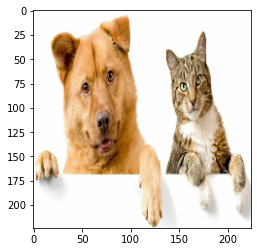

In [13]:
image = read_image('data/cat_and_dog.jpg')
plt.imshow(image/255)

In [14]:
pred_label, pred_prob = top_k_predictions(image)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

collie: 11.6%
basenji: 9.2%
lion: 7.6%


We generate class activation heatmap for "chow," the class index is 260

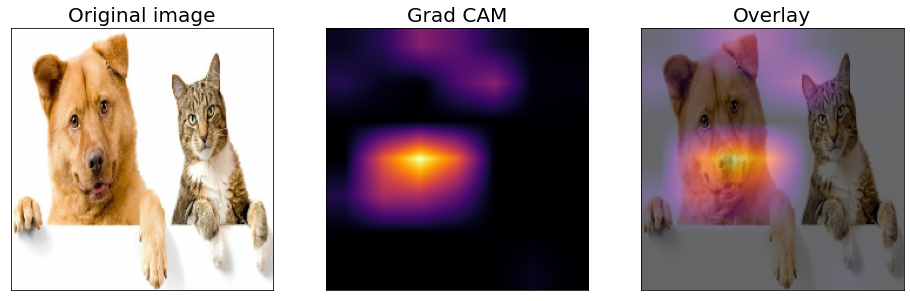

In [16]:
heatmap = gradcam(image, model, target_class_idx=260)

display_gradcam(image, heatmap)

We generate class activation heatmap for "egyptian cat," the class index is 285

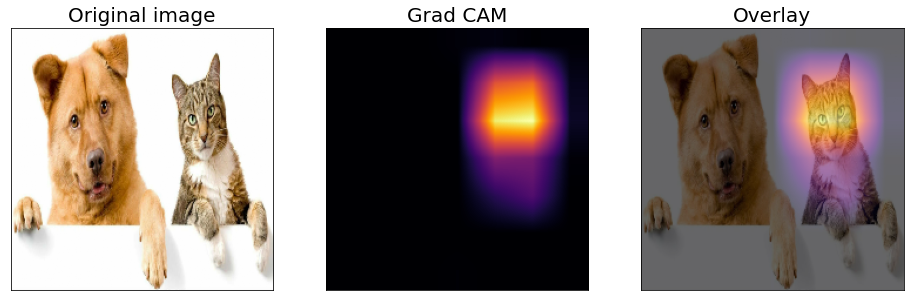

In [17]:
heatmap = gradcam(image, model, target_class_idx=285)

display_gradcam(image, heatmap)

## [2. Layer-CAM (Peng-Tao et al. 21)](http://mftp.mmcheng.net/Papers/21TIP_LayerCAM.pdf)

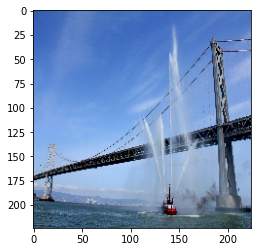

In [18]:
image = read_image('data/fireboat.jpg')
plt.imshow(image/255)

In [19]:
pred_label, pred_prob = top_k_predictions(image)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

fireboat: 98.6%
drilling platform: 0.3%
crane: 0.2%


In [20]:
layer_names = ['block5_pool', 'block4_pool', 'block3_pool']

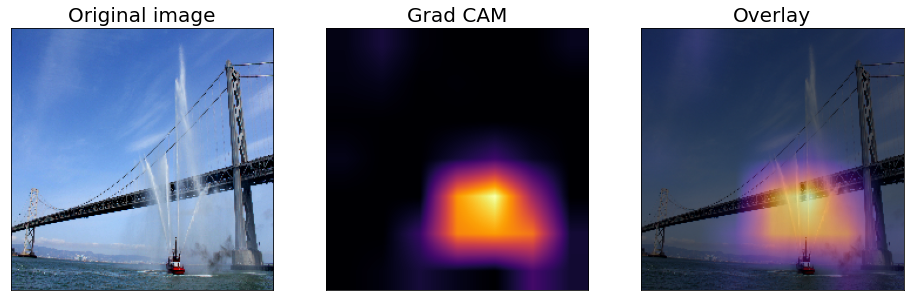

In [26]:
heatmap = gradcam(image, model)

display_gradcam(image, heatmap)

In [27]:
# Generate class activation heatmap
heatmaps = []
for layer_name in layer_names:
    heatmap = gradcam(image, model, layer_name)
    print(heatmap.shape)
    heatmaps.append(heatmap)

(7, 7)
(14, 14)
(28, 28)


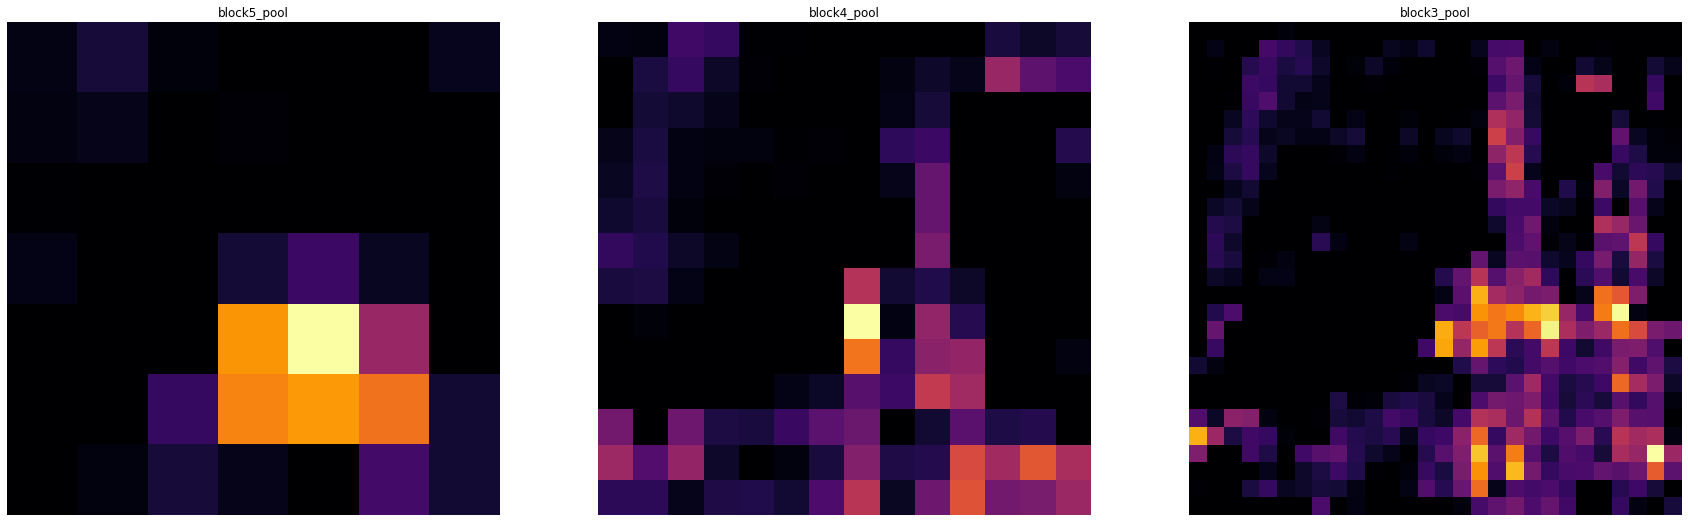

In [28]:
_, axes = plt.subplots(1, len(heatmaps), figsize=(30, 10))
for idx, name, hm in zip(range(len(heatmaps)), layer_names, heatmaps):
    axes[idx].imshow(hm, cmap=cm.inferno); 
    axes[idx].axis('off');
    axes[idx].set_title(name);
plt.show()

In [29]:
hm_out = np.zeros((28, 28))
for hm in heatmaps:
    hm_out += cv2.resize(hm.numpy(), (28, 28))
hm_out /= tf.math.reduce_max(hm_out)

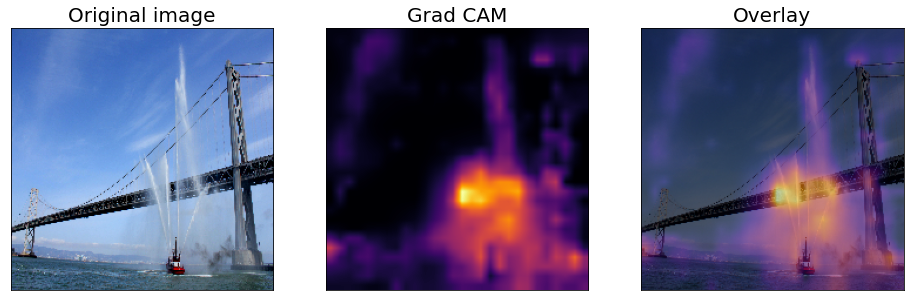

In [30]:
display_gradcam(image, hm_out)

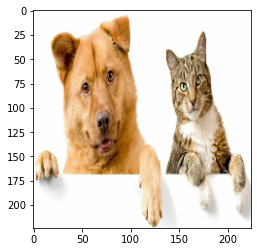

In [31]:
image = read_image('data/cat_and_dog.jpg')
plt.imshow(image/255)

In [32]:
pred_label, pred_prob = top_k_predictions(image)
for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')

collie: 11.6%
basenji: 9.2%
lion: 7.6%


In [33]:
layer_names = ['block5_pool', 'block4_pool', 'block3_pool']

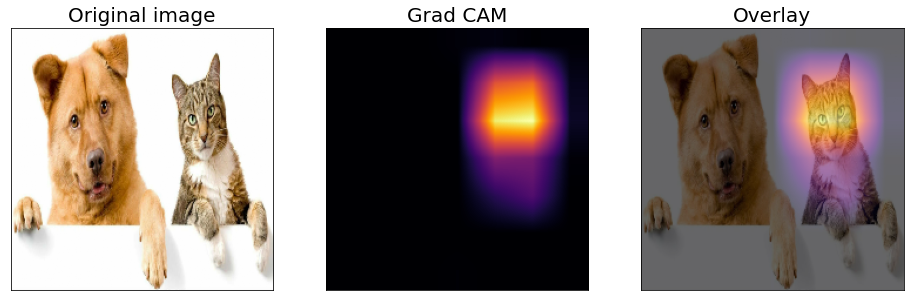

In [41]:
heatmap = gradcam(image, model, target_class_idx=285)

display_gradcam(image, heatmap)

In [42]:
# Generate class activation heatmap
heatmaps = []
for layer_name in layer_names:
    heatmap = gradcam(image, model, layer_name, target_class_idx=285)
    print(heatmap.shape)
    heatmaps.append(heatmap)

(7, 7)
(14, 14)
(28, 28)


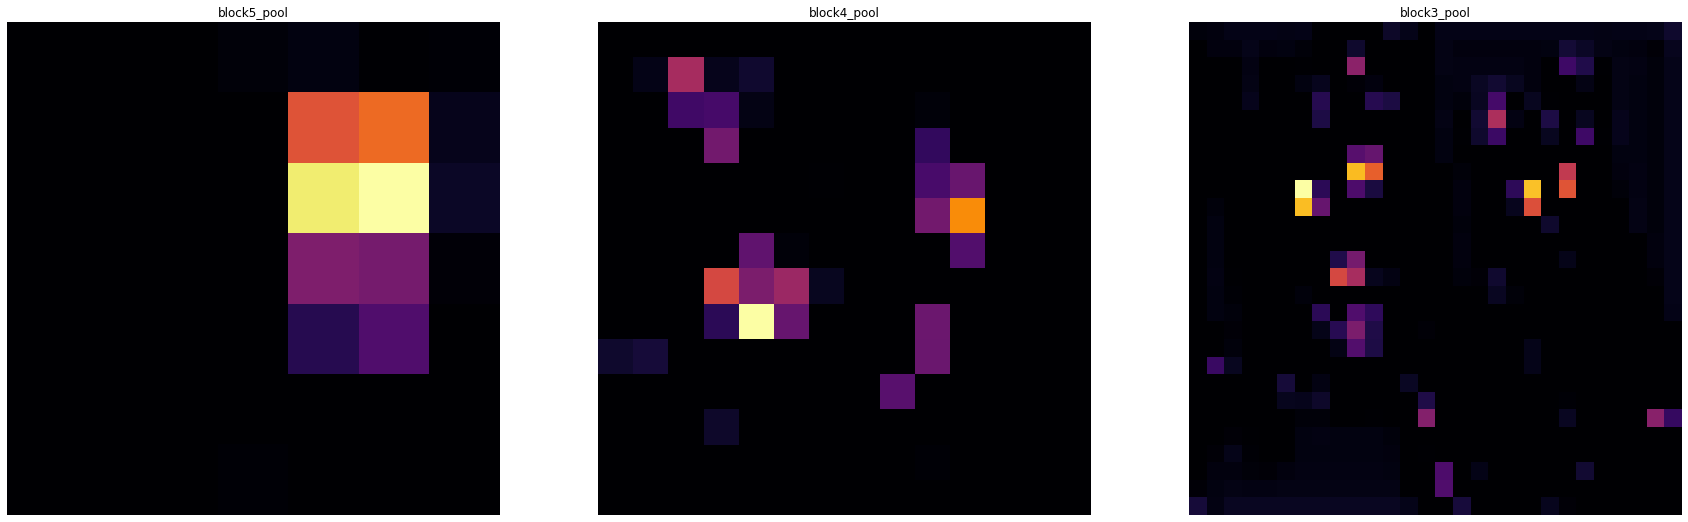

In [43]:
_, axes = plt.subplots(1, len(heatmaps), figsize=(30, 10))
for idx, name, hm in zip(range(len(heatmaps)), layer_names, heatmaps):
    axes[idx].imshow(hm, cmap=cm.inferno); 
    axes[idx].axis('off');
    axes[idx].set_title(name);
plt.show()

In [44]:
hm_out = np.zeros((28, 28))
for hm in heatmaps:
    hm_out += cv2.resize(hm.numpy(), (28, 28))
hm_out /= tf.math.reduce_max(hm_out)

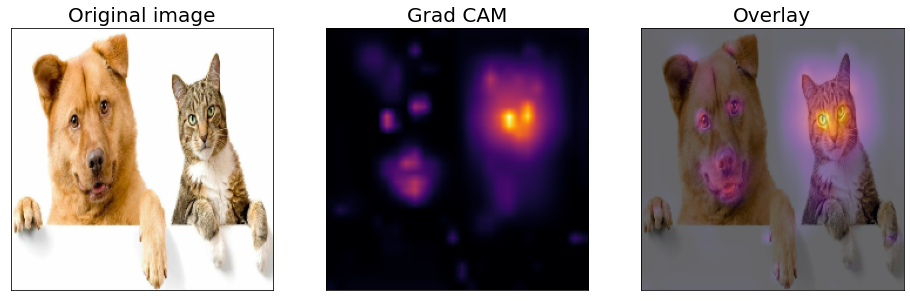

In [45]:
display_gradcam(image, hm_out)